<a href="https://colab.research.google.com/github/ryanbbrown/data/blob/main/NBA_Investment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
# imports

## data processing
import pandas as pd
import numpy as np

## visualization
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px

## modeling
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/ryanbbrown/data/main/school/mis373/CSV-Hall-of-fame-train.csv')

In [3]:
df_model = pd.get_dummies(df)

In [4]:
df.head()

,league,games,minutes,pts,offReb,defReb,reb,asts,stl,blk,turnover,pf,fga,fgm,fta,ftm,tpa,tpm,totalSeasons,Position,firstSeason,lastSeason,careerEnded,yrsRetired2004,class
0,N,408,9825,5232,476,824,1300,866,265,175,700,1214,4074,2031,1495,1125,153,45,9,G,1982,1990,1,14,0
1,N,51,0,587,0,0,0,158,0,0,0,114,620,222,181,143,0,0,1,G,1949,1949,1,55,0
2,N,265,0,1712,0,0,72,311,0,0,0,392,2190,655,620,402,0,0,5,G,1946,1950,1,54,0
3,N,133,2587,992,55,198,253,291,123,14,207,311,824,378,130,102,349,134,2,G,2003,2004,0,0,0
4,N,8,28,7,0,2,2,0,0,0,1,4,6,2,5,3,0,0,1,G,2004,2004,0,0,0


# Step 2: Exploring the data

### 2.1 Variable vs. target visualization
Use the Preprocess or the Visualization tab to examine the distribution of different variables with respect to the target variables. Suggest two attributes that are likely to be predictive of a player’s induction to the hall of fame. Describe the pattern you observe to support your choice.

**Minutes played and points scored are likely to be predictive of a player's induction to the hall of fame, since the difference in an inducted vs non-inducted player's average quantity for each of these attributes is quite large based on the visualizations.**

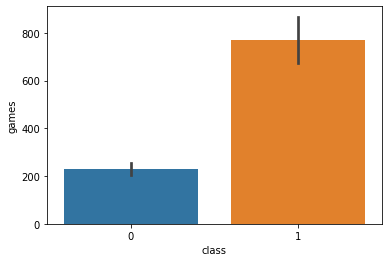

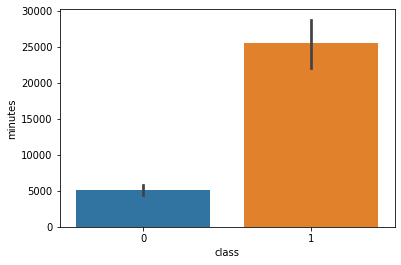

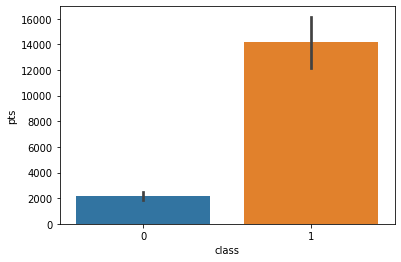

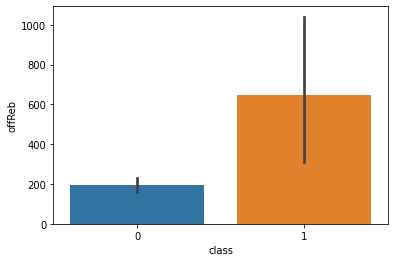

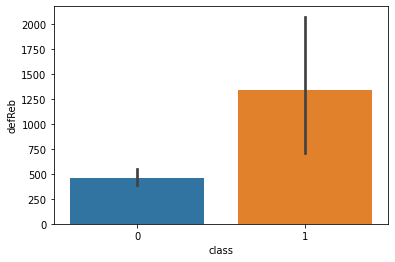

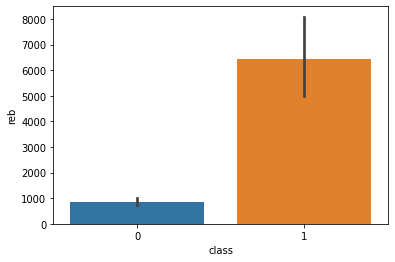

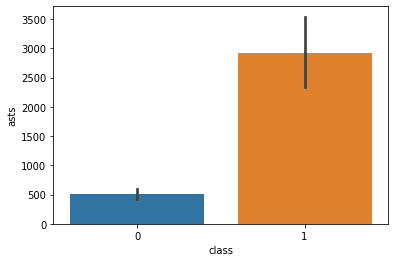

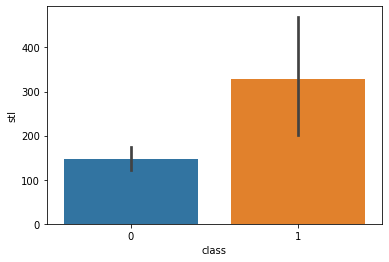

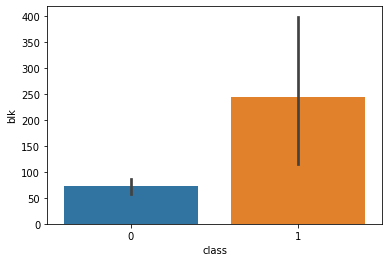

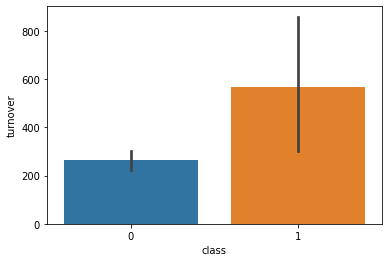

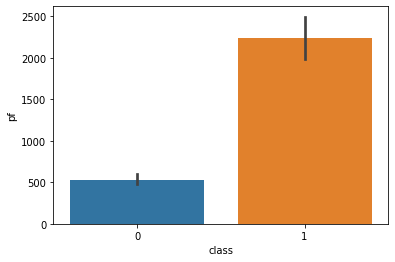

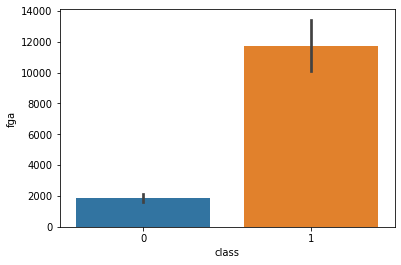

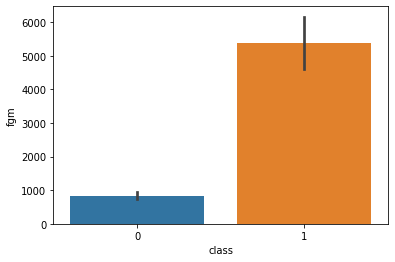

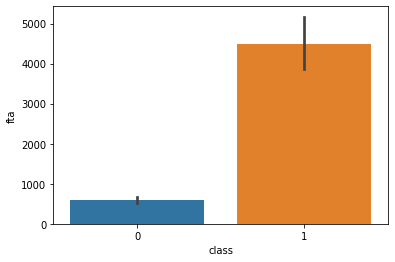

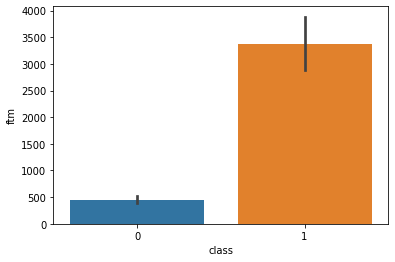

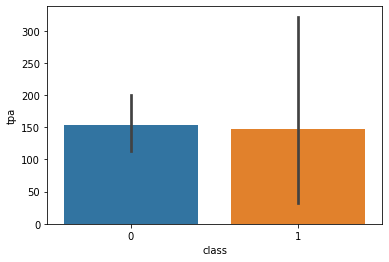

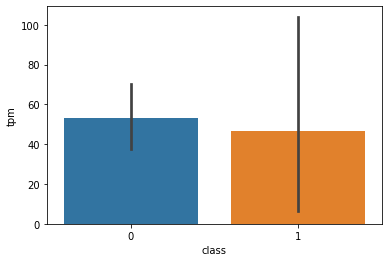

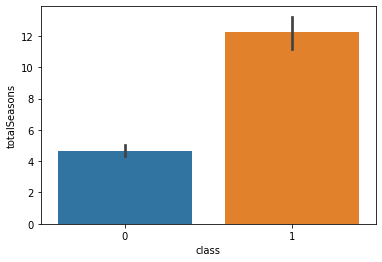

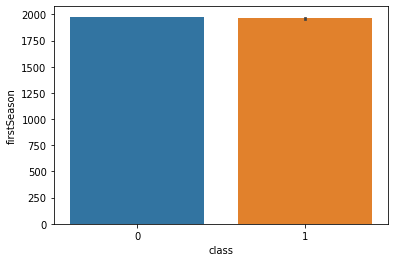

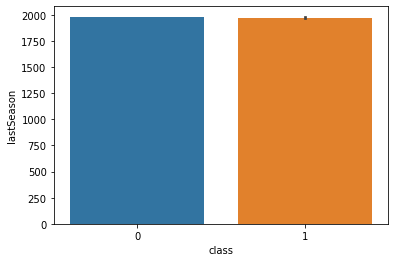

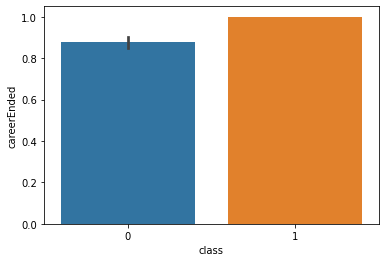

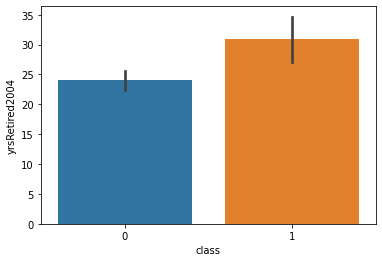

In [5]:
df_numerical = df.select_dtypes('number')

for col in df_numerical.columns:
    if col != 'class':
            sns.barplot(data=df, x='class', y=col, estimator=np.mean)
            plt.show()

### 2.2 Classification accuracy rate
Using classification accuracy rate as the evaluation measure, which model best predicts whether or not a player will be inducted?

**Random forest best predicts whether or not a player will be inducted (using accuracy as a measure).**

In [6]:
# setting up X and y
X = df_model.drop('class', axis=1)
y = df_model['class']

# initializing models
tree = DecisionTreeClassifier(random_state=1)
bagging = BaggingClassifier(n_estimators=30, random_state=1)
random_forest = RandomForestClassifier(n_estimators=60, max_features=6, random_state=1)
naive_bayes = GaussianNB()
knn = KNeighborsClassifier(n_neighbors=5)

# creating models dictionary
models = {
    'Decision Tree' : tree,
    'Bagging' : bagging,
    'Random Forest' : random_forest,
    'Naive Bayes' : naive_bayes,
    'K-Nearest Neighbors' : knn
}

In [7]:
# using 10-fold CV to get average model accuracy
for name, model in models.items():
    accuracies = cross_val_score(model, X, y, scoring='accuracy', cv=10)
    print('{} Average Accuracy: {:.4f}'.format(name, np.mean(accuracies)))

Decision Tree Average Accuracy: 0.9596
Bagging Average Accuracy: 0.9676
Random Forest Average Accuracy: 0.9737
Naive Bayes Average Accuracy: 0.9029
K-Nearest Neighbors Average Accuracy: 0.9697


### 2.3 Area under the ROC curve
Using the Area under the ROC curve (ROC area), which model yields the largest area under the ROC?

**Random forest yields the largest area under the ROC.**

In [8]:
# using 10-fold CV to get average model AUROC
for name, model in models.items():
    roc_aucs = cross_val_score(model, X, y, scoring='roc_auc', cv=10)
    print('{} Average Area Under ROC Curve: {:.4f}'.format(name, np.mean(roc_aucs)))

Decision Tree Average Area Under ROC Curve: 0.8853
Bagging Average Area Under ROC Curve: 0.9329
Random Forest Average Area Under ROC Curve: 0.9695
Naive Bayes Average Area Under ROC Curve: 0.9431
K-Nearest Neighbors Average Area Under ROC Curve: 0.9106


### 2.4 Comparing measures
Given your goal is to identify and invest in a set of players likely to be inducted to the Hall of Fame, which
of the two measures above (classification accuracy rate or ROC area) is more appropriate for selecting the
model to inform your investments? Explain your answer. (Note that while classification accurate rate and
ROC area may often agree, in some cases the classification accuracy of two models may be comparable,
while the ROC area of one may be larger than the other.)

**Classification accuracy rate is more appropriate for selecting the model to inform our investments given our goal. This is becuase we're only going to be interested in the model's performance at a particular threshold, since that has to be chosen so we can get definitive predictions on whether or not to invest. Classification accuracy looks at a specific threshold, while area under the ROC curve is looking at all possible thresholds.**

# Step 3: Analysis and Model Improvement

### 3.1 Predictors of future induction
Using an appropriate measure list the three best predictors of a player’s future induction to the hall of
fame. Here, do not use visualization, as above, but use a relevant measure to quantify and rank the
attributes by their predictive value. Explain what measure you used to select these predictors and why.

**We ranked attributes for their predictive value by looking at the sum of the feature importances from each feature for the tree model and the random forest model. We used feature importance because it's directly tied to how much impact that feature had on the model's prediction, and we did it for both random forest and tree so that we could cover as many models as possible. The other two models didn't have feature importance attributes, but as they had similar accuracy and area under the ROC curve to these two models, we thought that it was a fine proxy for which three features were the most predictive. The three most predictive features ended up being free throws attempted, free throws made, and field goals attempted.**

In [9]:
tree.fit(X, y)
tree_feature_importances = tree.tree_.compute_feature_importances(normalize=False)

random_forest.fit(X, y)
random_forest_feature_importances = random_forest.feature_importances_

In [10]:
total_feature_importances = tree_feature_importances + random_forest_feature_importances

In [11]:
df_importance = pd.DataFrame()

df_importance['Column'] = X.columns
df_importance['Importance'] = total_feature_importances

In [12]:
df_importance.sort_values('Importance', ascending=False).head(3)

,Column,Importance
13,fta,0.259765
14,ftm,0.129072
11,fga,0.120326


### 3.2 Cumulative career statistics
Most predictors reflect career statistics such as points, assists, and rebounds represent a cumulative
value, over a player’s career. Do you believe this an informative predictor for both young and older players’
likelihood of being inducted to the Hall of Fame? Explain your answer. If your answer is no, please suggest
how these attributes may be revised such that they useful information to predict a player’s merit. If your
answer is yes, comment on why the cumulative values may contain predictive information on a player’s
likelihood of being inducted

**No, we don't believe this is an informative predictor for both young and older players, since younger players will inherently have lower cumulative values for career statistics (due to having played for less time overall) even if they're on pace to have higher cumulative values later in their career when they've played as long as the older players. These attributes could be revised by being scaled for the amount of time the player has played, in terms of games, minutes, seasons, or years.**

### 3.3 Improving the model's performance

As discussed in class, an important step in developing predictive models pertains to (a) removing
predictors (features or variables) that do not improve or that undermine out-of-sample prediction
(through overfitting), (b) adding new information that is not included in the current data set (birth place
of a player), or (c) constructing new variables (i.e., Feature Construction). New variables can be
constructed by applying transformations on existing variables, such as by calculating the average career
points per game from the cumulative number of pointe), or by producing a function using multiple
variables (e.g., computing the product or ratio of the number of points and the number of rebounds).

Start with your best model produced so far and aim to improve this model through either removing
existing attributes, or the creation of new attributes. See guidelines below on how to produce new
variables.

To evaluate whether the changes you have made yield an improvement, examine the difference in
performance before and after the change (namely before and after the removal of an existing variable or
after the inclusion of a new variable you created). Towards the performance evaluation use the 10-foldcross-validation procedure and a relevant measure of performance for our problem. In particular, use
the measure of performance that you suggested in question 2.4 to be more appropriate for this task.

If you found that the removal of an existing variable improves your model specify which variables were
removed. In addition, describe all your attempts to produce new variables (even if the change did not
improve the model) and outline what the new variables where and what was the effect on your model’s
performance.

Using 10-fold-cross-validation procedure report your final (best) model’s classification accuracy rate
and AUC area. 

**Based on the information provided in the dataset, only removing predictors and constructing new variables were relevant approaches.** 

**First, we tried creating new predictors: the percentage of field goals, free throws, and three pointers made. We thought that this would help by creating an explicit connection between the attempted and made shots, but it didn't improve the accuracy so we didn't keep the change.**

**Second, we tried modified existing predictors by scaling career statistics by the number of games played, as discussed in (3.2). This did increase the accuracy, so we kept this change.**

**Finally, we tried removing various predictors. We thought removing minutes might be helpful since some players had 0 minutes despite having played in many games and having many points, but this decreased accuracy. We thought removing the first and last season might be helpful since totalSeasons captures the difference, but this also decreased accuracy so we didn't keep it. We thought that removing statistics relating to three-pointers might be helpful since the measure is uneven because three pointers didn't exist until 1979, and that did improve the accuracy slightly so we kept that change.**

**The accuracy and area under the ROC curve for the best model (with all the positive changes) were 0.9757 and 0.9753, respectively.**


In [13]:
# FEATURE CREATION: creating fg, ft, and tp percentages

df_model_v2 = df_model.copy()
df_model_v2['fg_pct'] = df_model_v2['fgm'] / df_model_v2['fga']
df_model_v2['ft_pct'] = df_model_v2['ftm'] / df_model_v2['fta']
df_model_v2['tp_pct'] = df_model_v2['tpm'] / df_model_v2['tpa']

df_model_v2['fg_pct'].fillna(0, inplace=True)
df_model_v2['ft_pct'].fillna(0, inplace=True)
df_model_v2['tp_pct'].fillna(0, inplace=True)

X_2 = df_model_v2.drop('class', axis=1)
y_2 = df_model_v2['class']

accuracies = cross_val_score(models['Random Forest'], X_2, y_2, scoring='accuracy', cv=10)
print('Average Accuracy: {:.4f}'.format(np.mean(accuracies)))

Average Accuracy: 0.9696


In [14]:
# FEATURE MODIFICATION: scaling career statistics by number of games

df_model_v2 = df_model.copy()

for col in ['pts', 'offReb', 'defReb', 'reb', 'asts', 'stl', 'blk', 'turnover']:
    df_model_v2[col] = df_model_v2[col] / df['games']

X_2 = df_model_v2.drop('class', axis=1)
y_2 = df_model_v2['class']

accuracies = cross_val_score(models['Random Forest'], X_2, y_2, scoring='accuracy', cv=10)
print('Average Accuracy: {:.4f}'.format(np.mean(accuracies)))

Average Accuracy: 0.9757


In [15]:
# FEATURE REMOVAL: dropping potentially bad predictors
df_copy = df_model.copy()

df_model_v2 = df_copy.drop(['minutes'], axis=1)
X_2 = df_model_v2.drop('class', axis=1)
y_2 = df_model_v2['class']
accuracies = cross_val_score(models['Random Forest'], X_2, y_2, scoring='accuracy', cv=10)
print('Average Accuracy after dropping minutes: {:.4f}'.format(np.mean(accuracies)))


df_model_v3 = df_copy.drop(['firstSeason', 'lastSeason'], axis=1)
X_3 = df_model_v3.drop('class', axis=1)
y_3 = df_model_v3['class']
accuracies = cross_val_score(models['Random Forest'], X_3, y_3, scoring='accuracy', cv=10)
print('Average Accuracy after dropping first and last season: {:.4f}'.format(np.mean(accuracies)))


df_model_v4 = df_copy.drop(['tpa', 'tpm'], axis=1)
X_4 = df_model_v4.drop('class', axis=1)
y_4 = df_model_v4['class']
accuracies = cross_val_score(models['Random Forest'], X_4, y_4, scoring='accuracy', cv=10)
print('Average Accuracy after dropping three pointers: {:.4f}'.format(np.mean(accuracies)))

Average Accuracy after dropping minutes: 0.9717
Average Accuracy after dropping first and last season: 0.9696
Average Accuracy after dropping three pointers: 0.9738


In [16]:
# FINAL: implementing all the positive changes for the best model
df_model_final = df_model.copy()

for col in ['pts', 'offReb', 'defReb', 'reb', 'asts', 'stl', 'blk', 'turnover']:
    df_model_final[col] = df_model_final[col] / df['games']

df_model_final = df_model_final.drop(['tpa', 'tpm'], axis=1)

X_2 = df_model_final.drop('class', axis=1)
y_2 = df_model_final['class']

accuracies = cross_val_score(models['Random Forest'], X_2, y_2, scoring='accuracy', cv=10)
print('Average Accuracy: {:.4f}'.format(np.mean(accuracies)))

roc_aucs = cross_val_score(models['Random Forest'], X_2, y_2, scoring='roc_auc', cv=10)
print('Average ROC AUCs: {:.4f}'.format(np.mean(roc_aucs)))

Average Accuracy: 0.9757
Average ROC AUCs: 0.9753


In [17]:
df_model_export = df.copy()

for col in ['pts', 'offReb', 'defReb', 'reb', 'asts', 'stl', 'blk', 'turnover']:
    df_model_export[col] = df_model_export[col] / df['games']

df_model_export = df_model_export.drop(['tpa', 'tpm'], axis=1)

In [18]:
df_model_export.to_csv('NBA_data_final.csv', index=False)

# 4. Investment Decisions

### 4.1 Choosing an eval measure / plot
What evaluation measure/plot (i.e., classification accuracy rate, ROC area, lift chart, or profit chart) would be most appropriate in order to select the predictive model based on which to select players to invest in? Why?

**A profit chart would be the most appropriate evaluation measure to select the best predictive model, since our overall goal is to maximize profit from NBA investments. Classification accuracy rate and ROC area don't consider how much we profit from a successful investment or how much we lose from an unsuccessful investment. A profit chart, though, considers these things and also considers a dynamic threshold that can be changed to maximize our profit.**


### 4.2 Compare models

Use the training data with 10-fold cross-validation, as well as the evaluation measure/plot you selected in
(4.1), to compare between models and to select the model that performs best. Present your results to support
your choice of the best model to use. Explain in words how the evidence you present supports your choice of
model

**Our choice for the best model to use is bagging, because it has the highest maximum profit on the profit chart of $1,960,000. This evidence supports our choice of model because based on the discussion in (4.1), the model with the highest peak in its profit chart is the best-performing model for investment results, which is our goal.**

#### Result screenshots

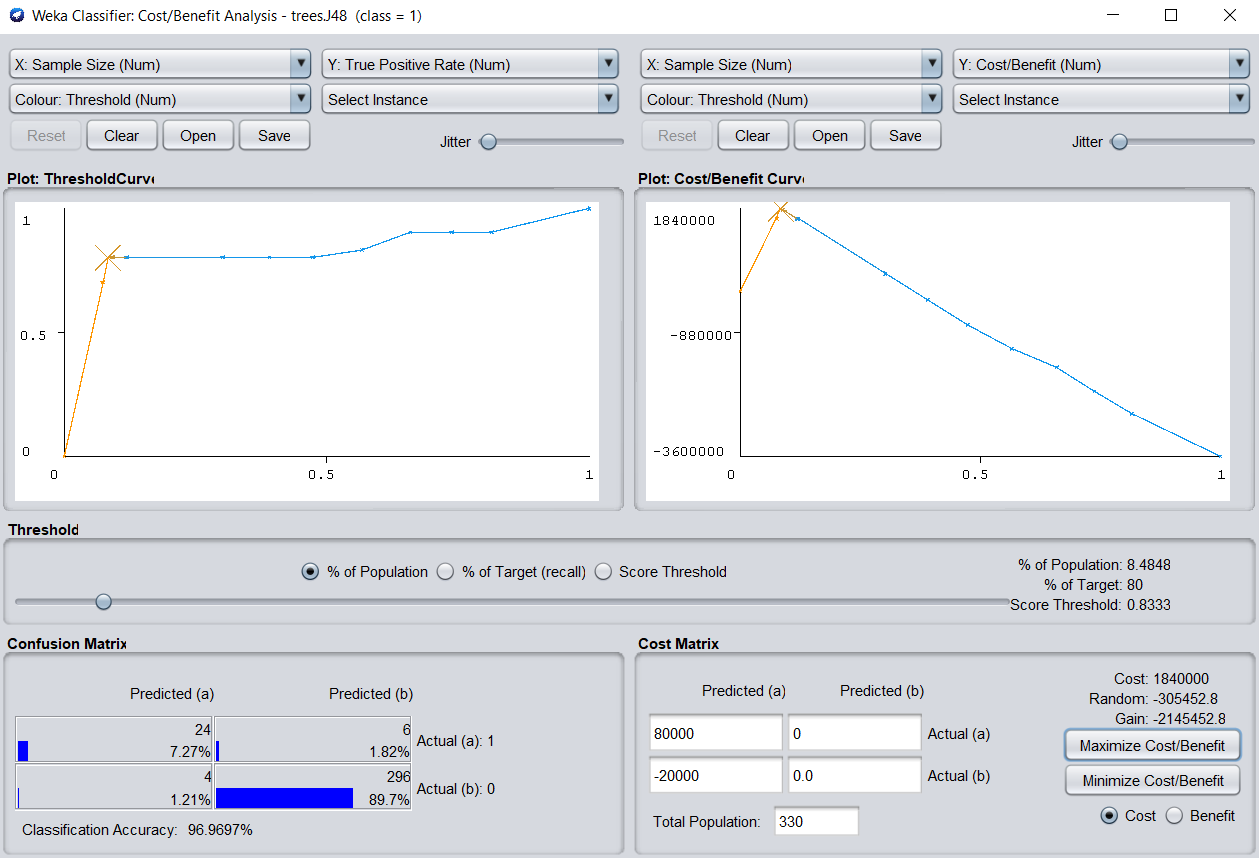

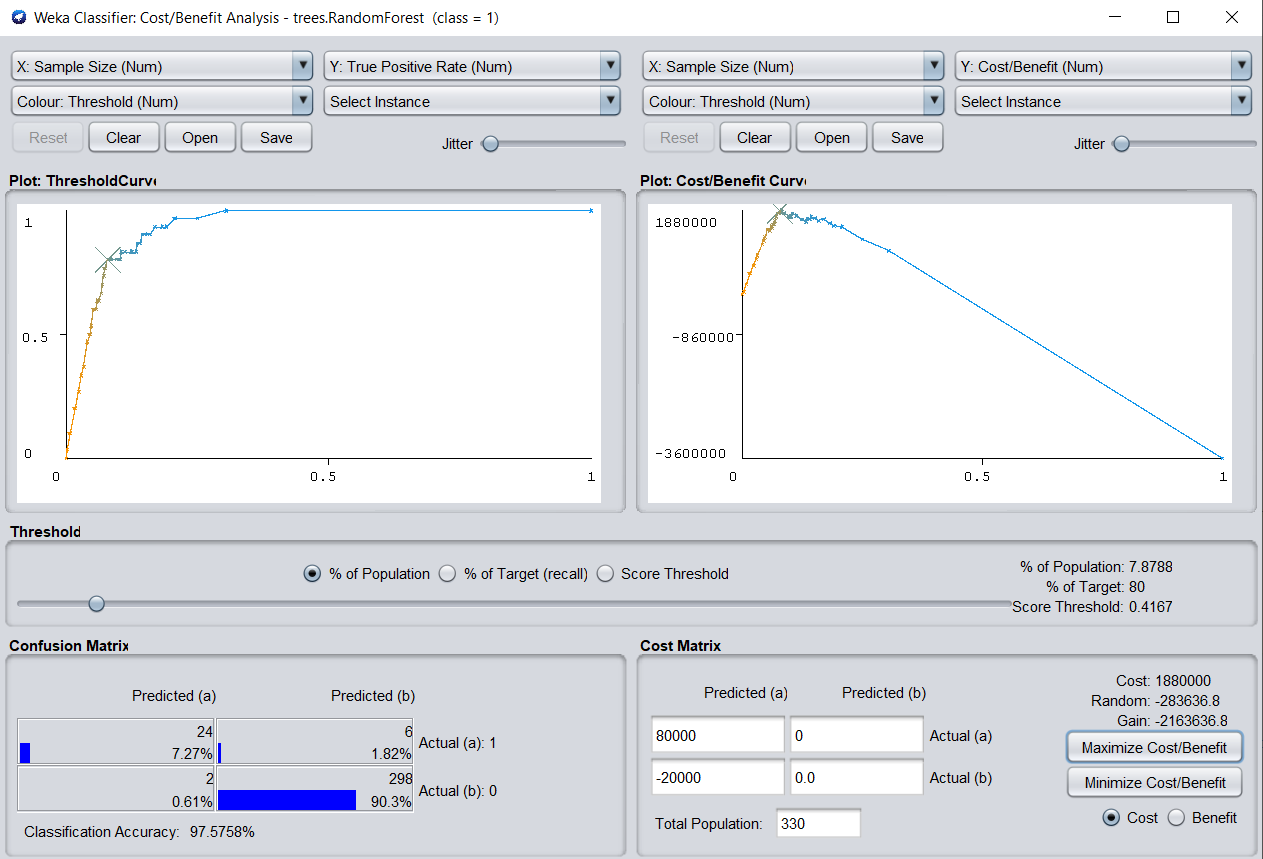

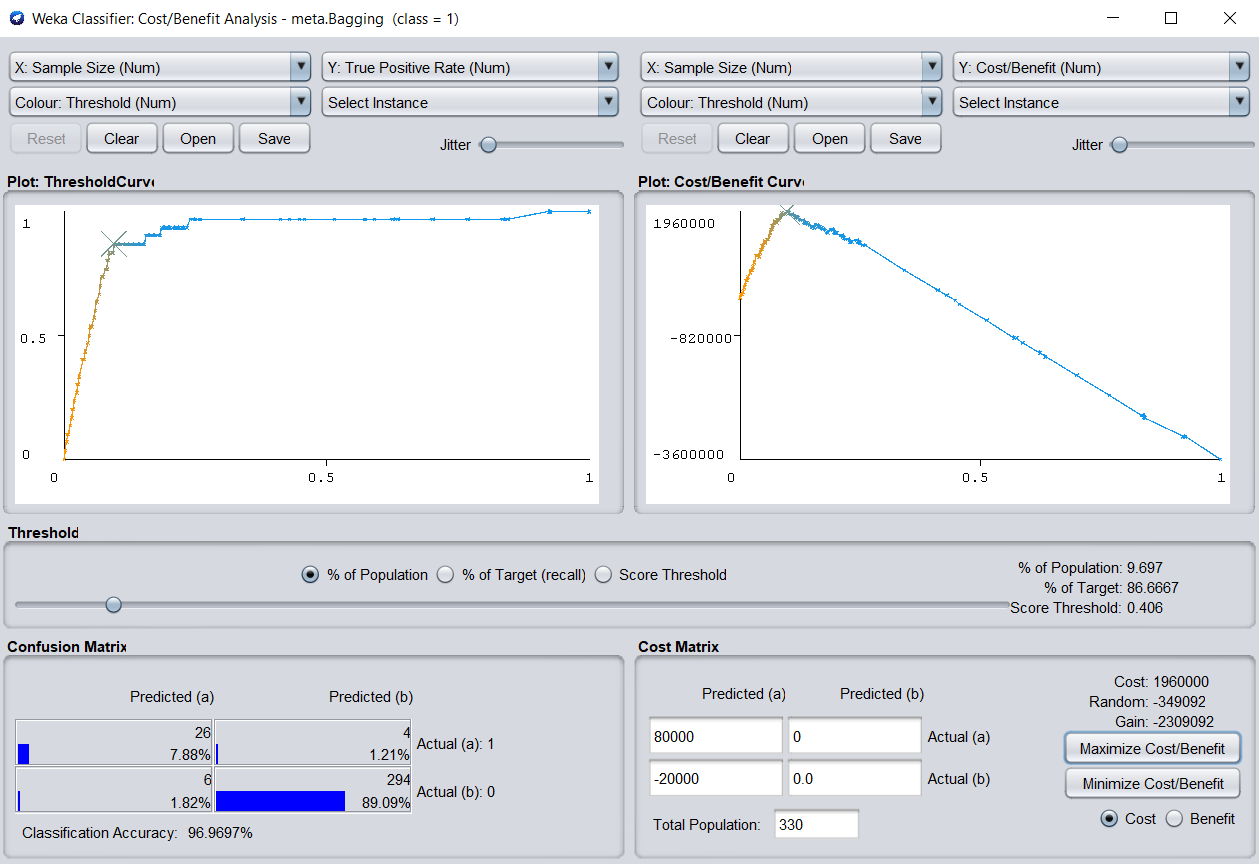

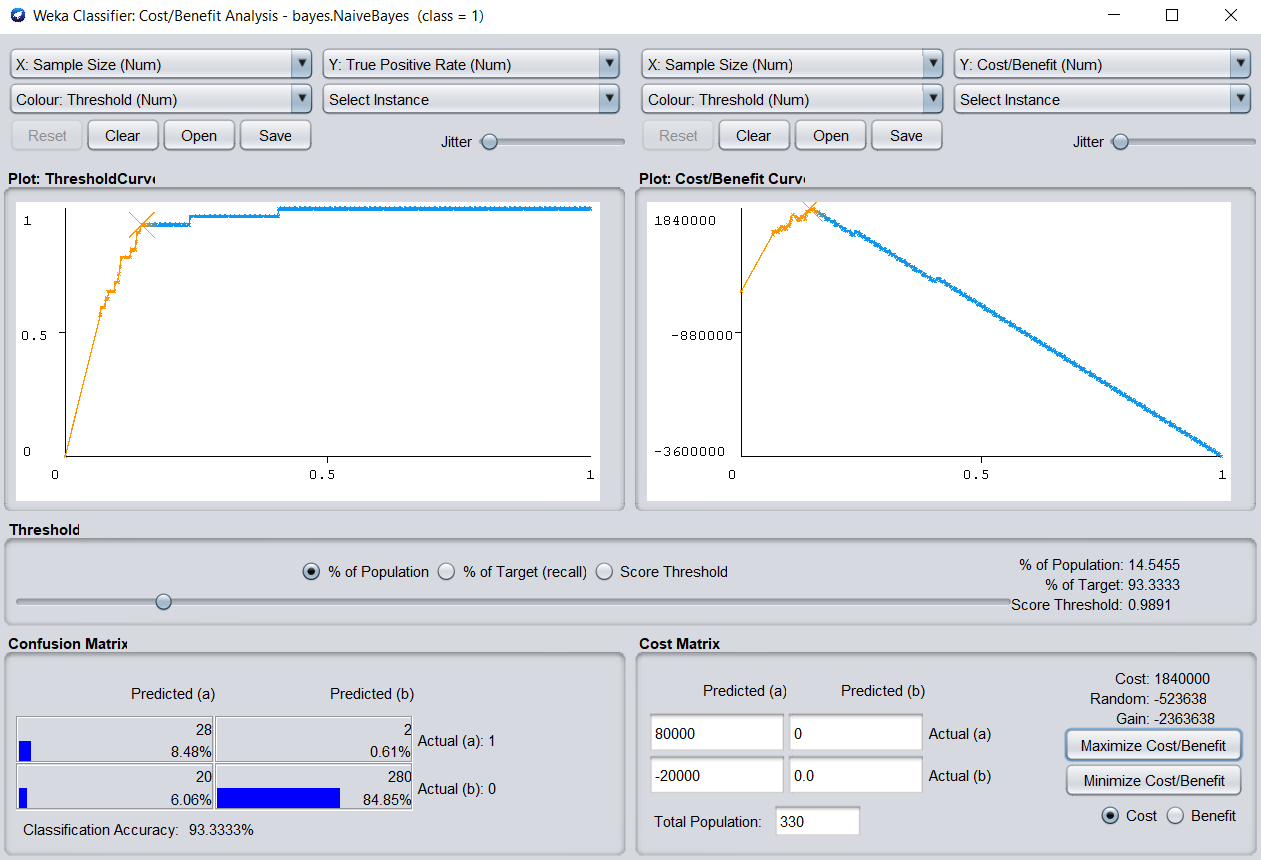

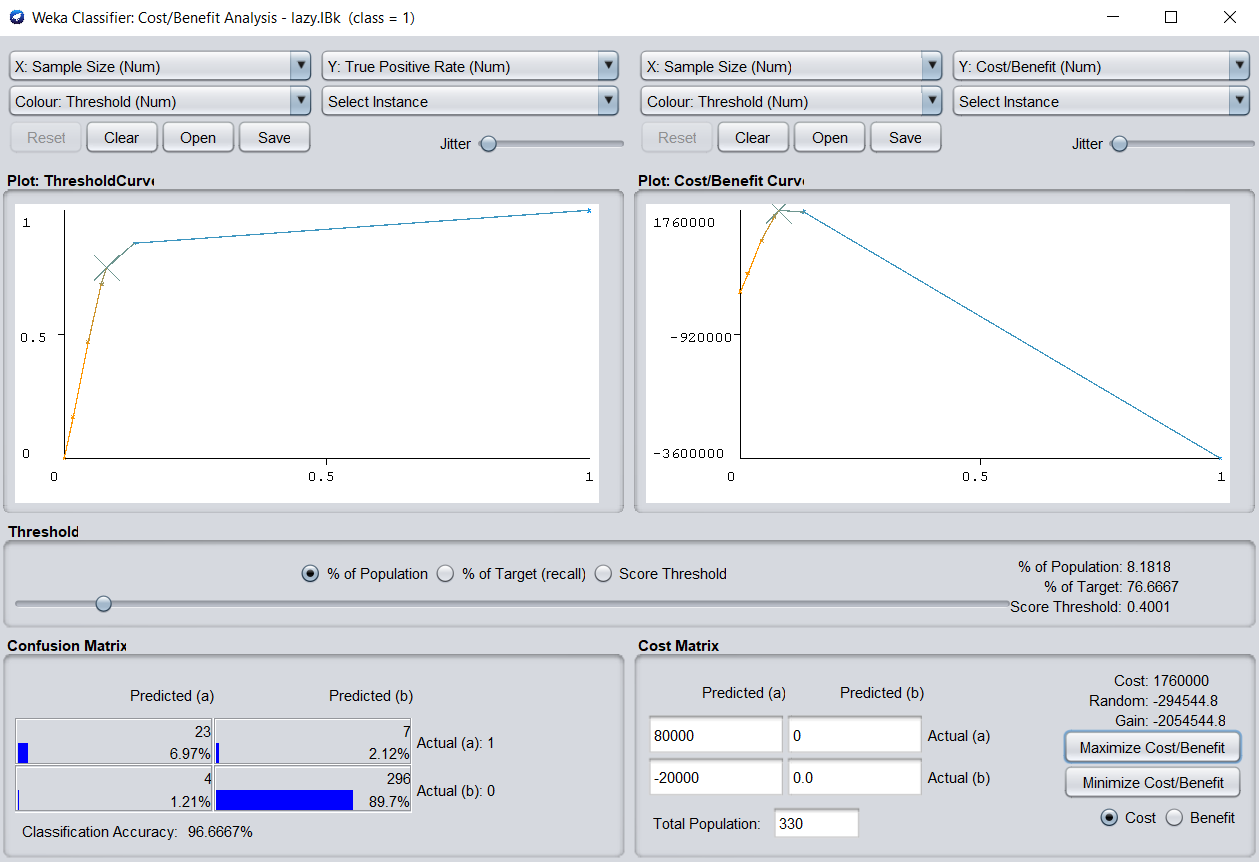

### 4.3 Formulate an investment strategy
Using the model selected in 4.2, formulate clearly the investment strategy you will use to decide which
players to invest in. The strategy should include the following:

1. Which model to use (along with corresponding parameters, such as number and type of models in
bagging ensemble, number of K nearest neighbors, etc.)
2. Given your model’s estimated probability of induction, above what probability threshold to invest in a
player’s memorabilia.

**Our investment strategy will use a bagging model with 30 base models, and the probability threshold to invest in a player's memorabilia will be 0.406.**

### 4.4 Deploy the investment strategy

**Done.**



### 4.5 Investment results
Print the list of players (along with their Example number) you will invest in, and report your profit.

**The `inst#` of the players that we would invest in are: [4, 15, 25, 35, 102, 108, 145, 150, 151, 152, 153, 154, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165], and our profit would be $960,000.**

In [19]:
predictions = pd.read_csv('https://raw.githubusercontent.com/ryanbbrown/data/main/school/mis373/predictions.csv')

In [20]:
predictions.head()

,inst#,actual,predicted,prediction
0,1,0,0,0.997
1,2,0,0,0.997
2,3,0,0,0.997
3,4,0,1,0.630
4,5,0,0,0.996


In [21]:
predictions['prediction_1_confidence'] = (
    predictions.apply(lambda row: 1-row['prediction'] if row['predicted']==0 else row['prediction'], axis=1)
)

In [22]:
predictions['prediction_real'] = (
    predictions['prediction_1_confidence'].apply(lambda x: 1 if x >= 0.406 else 0)
)

In [23]:
def calc_profit(row):
    if row['prediction_real'] == 0:
        return 0
    elif row['prediction_real'] == 1:
        if row['actual'] == 1:
            return 80000
        else:
            return -20000

predictions['profit'] = (
    predictions.apply(lambda row: calc_profit(row), axis=1)
)

In [24]:
good_predictions = predictions[predictions['prediction_real']==1]

In [25]:
print('Players to invest in based on strategy:', good_predictions['inst#'].values.tolist())

Players to invest in based on strategy: [4, 15, 25, 35, 102, 108, 145, 150, 151, 152, 153, 154, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165]


In [26]:
print('Profit:', good_predictions['profit'].sum())

Profit: 960000
